In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)

In [ ]:
dls = ImageDataLoaders.from_folder(path, valid='val', 
    item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))

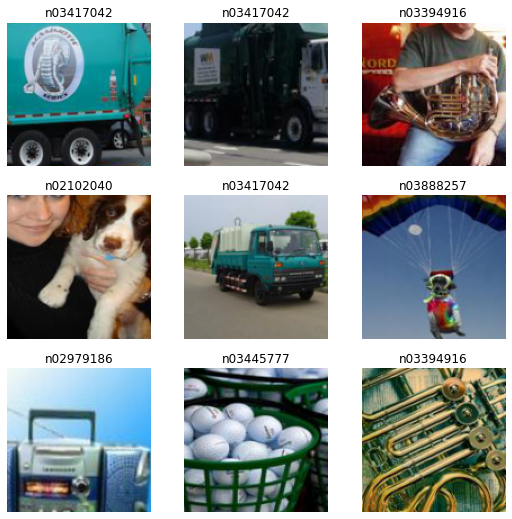

In [ ]:
dls.show_batch()

In [ ]:
fnames = get_image_files(path)

In [ ]:
dblock = DataBlock(get_items = get_image_files)

In [ ]:
dsets = dblock.datasets(path)

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

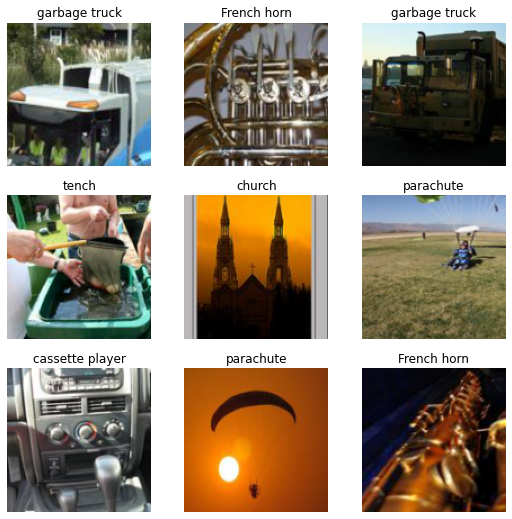

In [ ]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

dls = imagenette.dataloaders(path)
dls.show_batch()

In [ ]:
#learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False)

In [ ]:
#learn.lr_find()

In [ ]:
#for i in range(1):
#    learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False)
#    learn.fit_one_cycle(200, 1e-3)

In [ ]:
@delegates()
class AnkiDL(TfmdDL):
    def __init__(self, dataset=None, bs=None, scores=None,temp=None, **kwargs):
        super().__init__(dataset=dataset, bs=bs, **kwargs)
        self.scores = torch.ones([len(dataset)]) if scores is None else scores
        self.temp = 2. if temp is None else temp
    def reset(self):
        self.scores = torch.ones([len(self.scores)])
    def get_idxs(self):
        if self.n==0: return []
        if not self.shuffle: return super().get_idxs()
        #dist=F.mse_loss(self.scores, torch.zeros([self.n]),reduction='none')
        wgts=F.softmax(-1*self.scores/self.temp,dim=0)
        self._idxs=list(torch.multinomial(wgts,self.n,replacement=True)) #we make this public
        return self._idxs

In [ ]:
@patch
@delegates(Datasets.dataloaders)
def anki_dataloaders(self:Datasets, scores=None,temp=None, bs=64, **kwargs):
    xtra_kwargs = [{}] * (self.n_subsets-1)
    return self.dataloaders(bs=bs, dl_type=AnkiDL, dl_kwargs=({'temp':temp}, *xtra_kwargs), **kwargs)

@patch
@delegates(DataBlock.dataloaders)
def anki_dataloaders(self:DataBlock, source, path='.', verbose=False, **kwargs):
    dsets = self.datasets(source, verbose=verbose)
    kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
    return dsets.anki_dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

### Fix!!!

In [ ]:
#Not adding against correct indexes!!!!!!!!!this just loops through
class AnkiCb(Callback):
    run_train,run_valid = True, False
    def __init__(self,mom=0.5):
        self.mom=mom
    def before_step(self):
        with torch.no_grad():
            reduction=self.loss_func.reduction
            self.loss_func.reduction='none'
            loss = self.loss_func(self.pred, *self.yb).detach().cpu()
            correct=torch.argmax(self.pred,dim=1).detach().cpu()==self.yb[0].detach().cpu()
            sli=slice(learn.iter*learn.dls.train.bs,(learn.iter+1)*learn.dls.train.bs)
            idxs=self.dls.train._idxs[sli]
            self.dls.train.scores[idxs]=self.mom*self.dls.train.scores[idxs] + correct*(1-self.mom)*F.relu(1-loss)
            self.dls.train.scores[idxs]=self.mom*self.dls.train.scores[idxs]-(~correct)*(1-self.mom)*loss
            self.loss_func.reduction=reduction

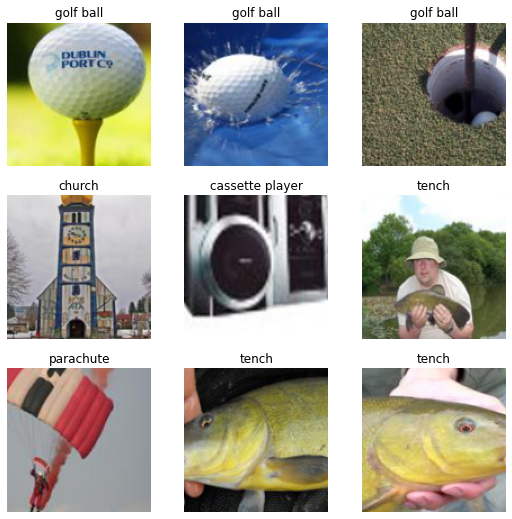

In [ ]:
dls = imagenette.anki_dataloaders(path)
dls.show_batch()

In [ ]:
dls.fake_l.__iter__??
dls.fake_l.d.create_batches??

In [ ]:
Has to be done at batch level instead of epoch level. Otherwise a single mistake will get way too much weight. 

SyntaxError: invalid syntax (3789922367.py, line 1)

In [ ]:
for i in range(1):
    learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False,cbs=[AnkiCb(0.3)])
    learn.dls.train.reset()
    learn.fit_one_cycle(10, 1e-3)
    #learn.dls.train.reset()

/home/molly/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,2.836759,2.715142,0.265987,00:14
1,1.805368,1.967509,0.373503,00:15
2,1.855880,1.674437,0.437452,00:13
3,0.427380,26.415724,0.123822,00:14
4,0.188795,43.520725,0.106752,00:14
5,0.062962,4.093631,0.125350,00:13
6,2.279273,1.975409,0.323567,00:14
7,0.335453,8.560356,0.136051,00:14
8,1.139595,2.096044,0.359490,00:14
9,2.394954,2.756276,0.156943,00:14


In [ ]:
len(learn.dls.train.scores),min(learn.dls.train.scores),max(learn.dls.train.scores)

(9469, tensor(-28.3370), tensor(1.))

In [ ]:
learn.dls.train.scores[-64:]

tensor([-1.6573,  1.0000,  1.0000, -2.4973,  1.0000,  1.0000,  1.0000, -1.9720,
        -3.6931, -1.6167, -0.1456, -0.2184, -1.5235,  1.0000, -2.7654, -1.0700,
        -2.2563, -1.4352, -2.2186, -4.4202,  0.1826,  0.2333, -2.1889, -0.1694,
        -1.6892,  0.2153, -1.8132, -2.0961, -1.9550,  0.0545,  0.1328, -1.4800,
        -3.0697,  1.0000, -0.0432, -0.9640, -0.0145,  0.0203, -1.9752, -1.6870,
        -3.2541, -1.1441,  1.0000,  0.1834, -2.1127, -1.6136, -3.2304,  1.0000,
        -2.2402, -0.0478, -1.1986, -0.1371, -1.3117,  1.0000, -1.3702, -2.5064,
        -1.6696, -0.1767, -1.4980, -3.1240,  1.0000, -1.4977, -2.8755,  1.0000])

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-28.336996 , -25.403297 , -22.469597 , -19.535896 , -16.602198 ,
        -13.668498 , -10.734798 ,  -7.801099 ,  -4.867399 ,  -1.9336996,
          1.       ], dtype=float32),
 <a list of 9469 BarContainer objects>)

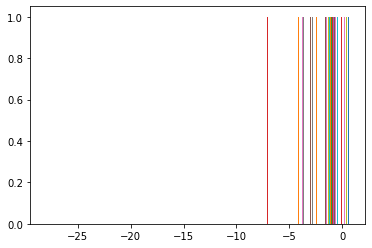

In [ ]:
plt.hist(learn.dls.train.scores)